In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
from scipy.fftpack import fft, ifft, fftshift, ifftshift
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.paramgen import distribution_param_generator
from effsim.effsim import EventSimulator
from effsim.effsim import NoiseMaker

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/chen/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)

In [4]:
tilt = config['tilt'] * degrees 
#clock = config['clock']
#beam_en = config['beam_enu0']
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
#tmat = pytpc.utilities.tilt_matrix(-tilt)
# efield_uvw = tmat.dot(efield)
# bfield_uvw = tmat.dot(bfield)
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = (config['max_beam_angle']*math.pi)/180
beam_origin_z = config['beam_origin_z']
#beampads = np.fromfile(config['beampads_path'], sep=',', dtype='int')

In [5]:
#Good events for run_0102 are: 357, 689, 765, 896, 714, 795, 305
full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
evt_ID = 896
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

#print(xyzs[:, 0:5])

In [7]:
######finding center of curvature
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
print(cx,cy) #The center of curvature of the track, in mm.


-3.064535268264883 3.9507750618784514


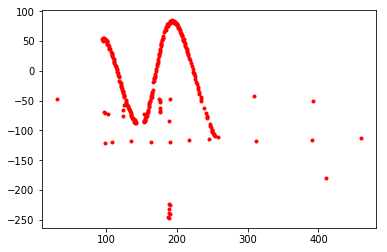

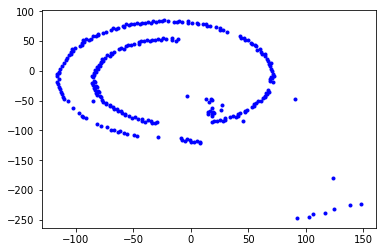

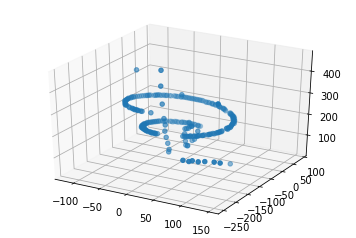

In [8]:
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'b.')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyzs[:,0],xyzs[:,1],xyzs[:,2])

In [9]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy)) # get calibrated set of data
uvw_values = uvw.values #transform pd file to arrays
print(cu,cv)
mcres, minChis, all_params, good_param_idx = mcfitter.process_event(uvw, cu, cv, return_details=True)

#print(mcres, minChis, all_params, good_param_idx)
print(mcres)
#print(uvw)

-3.064535268264883 112.56243119280789
{'x0': -0.0005114266314836487, 'y0': 2.6518979422099906e-05, 'z0': 0.38799373233523216, 'enu0': 2.772199770393475, 'azi0': -3.1742759189783363, 'pol0': 1.0520193480336462, 'posChi2': 96.20573480231958, 'enChi2': 4.144246667419604, 'vertChi2': 0.005245209113206032, 'lin_scat_ang': 1.8277739177569976, 'lin_beam_int': 366.8916221971684, 'lin_chi2': 4188.7173372041325, 'rad_curv': 105.48471118793105, 'brho': 0.18323115586125652, 'curv_en': 1.6079822806500748, 'curv_ctr_x': -3.064535268264883, 'curv_ctr_y': 112.56243119280789}


In [10]:
#num_evts = 10
sim = EventSimulator(config)
#pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)
#p = next(pgen)
evtClean, ctr = sim.make_event(mcres['x0'], mcres['y0'], mcres['z0'], mcres['enu0'], mcres['azi0'], mcres['pol0'])
#evtClean, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
print(ctr)
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)


type(pyevtClean)
# drift_vel=-2.54, clock=12.5, 

[ 3.42106291 16.46864391]


pytpc.evtdata.Event

In [ ]:
#treating the simulated data (starts with new_) as input, and run the fitting algorithm to see if we get the same parameters
#as the ones we used to generate the data.

sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
#sim_cx, sim_cy = ctr[0], ctr[1]
#The center of curvature of the track, in mm.

#new_xyz, (new_cu, new_cv) = mcfitter.preprocess(new_xyzs[:, 0:5],center=(new_cx, new_cy))
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy))
sim_uvw_values = sim_uvw.values
print(sim_cu, sim_cv)

sim_mcres, new_minChis, sim_all_params, sim_good_param_idx = mcfitter.process_event(sim_uvw, sim_cu, sim_cv, return_details=True)
print(sim_mcres)

In [ ]:
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
#plt.plot(sim_xy[:, 0], sim_xy[:, 1], 'b.')
plt.show()

In [ ]:
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,5],uvw_values[:,6],uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])


In [ ]:
good_params = all_params[good_param_idx.astype('int')] #the best points from each iteration, i.e. the ones whose
#                                                       chi2 values are in ``min_chis``
all_params = all_params.reshape((mcfitter.num_iters, mcfitter.num_pts, 6))

In [ ]:
print(minChis)
#print(good_params)
plt.plot(minChis, 'o-')
plt.plot(minChis.sum(1))
plt.semilogy()
plt.legend(('pos', 'en', 'vert'))
#plt.ylim(1e-6,1e3)

In [ ]:
#print(good_params)
params_name = ['x', 'y', 'z', 'en', 'azi', 'pol']

for v, l in zip(good_params.T, range(len(params_name))):
    plt.plot(v, label=l)
    plt.legend(params_name[l])
    plt.title('parameter: ' + str(params_name[l]))
    plt.show()
    
for v, l in zip(good_params.T, params_name):
    plt.plot(v, label=l)
plt.legend(loc=4)
plt.title("parameters' value through each iteration")
plt.show()
    
for v, l in zip(good_params.T, params_name):    
    plt.plot(v / v[0], label=l)
plt.title("parameters' value with respect to their initial value")
plt.legend(loc=4)

In [ ]:

plt.figure(figsize=(3.5, 2.5))
plt.plot(all_params[:, :, 3].ravel(), ',')
plt.xticks(np.arange(0, mcfitter.num_pts * (mcfitter.num_iters + 1), mcfitter.num_pts * 5),
               np.arange(0, mcfitter.num_iters + 1, 5))

plt.xlabel('Iteration number')
plt.ylabel('Proton energy [MeV]')
    
plt.tight_layout(pad=0.5)
plt.subplots_adjust(right=0.9)
    
plt.xlim(0)
plt.ylim(0)


In [ ]:
tracker = Tracker(mass_num, charge_num, beam_enu0, beam_mass, beam_charge, gas, efield, bfield, max_en) 
evtgen = EventGenerator(padplane, vd, 12.5, 280e-9, mass_num, 23.0, 500, 120e-15, tilt, 0.1e-3) 


num_iters = [5, 10, 15, 20]
num_pts = [100, 200, 300, 400, 500] #repeat(200)
red_factor = [0.5, 0.6, 0.7, 0.8, 0.9]

#for n, p, r in zip(num_iters, num_pts, red_factor):
#    minimizer = Minimizer(tracker, evtgen, num_iters, num_pts, red_factor)

allctrs = []
for n, p, r in zip(num_iters, num_pts, red_factor):
    ctrs = []
    for i in range(1):
        mcres, minChis, all_params, good_param_idx = mcfitter.process_event(xyz, cu, cv, return_details=True)
        good_params = all_params[good_param_idx.astype('int')]
        ctrs.append(pd.DataFrame(good_params.T, index=('x', 'y', 'z', 'en', 'azi', 'pol')))

    ctrs = pd.concat(ctrs, axis=1).T
    ctrs['num_iters'] = n
    ctrs['num_pts'] = p
    ctrs['red_factor'] = r

    allctrs.append(ctrs)

In [ ]:
num_evts = 10
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)
p = next(pgen)
evtRandom, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
pyevtRandom = sim.convert_event(evtRandom)
Random_xyzs = pyevtRandom.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
print(p)

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:66: RuntimeWarning: invalid value encountered in sqrt
  pcm = np.sqrt(((s - m1**2 - m2**2)**2 - 4 * m1**2 * m2**2) / (4 * s))
/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/relativity.py:67: RuntimeWarning: invalid value encountered in sqrt
  ppcm = np.sqrt(((s - m3**2 - m4**2)**2 - 4 * m3**2 * m4**2) / (4 * s))


In [ ]:
Random_xy = Random_xyzs[:, 0:2]
Random_xy_C = np.ascontiguousarray(Random_xy, dtype=np.double)
Random_cx, Random_cy = pytpc.cleaning.hough_circle(Random_xy_C)
#sim_cx, sim_cy = ctr[0], ctr[1]
#The center of curvature of the track, in mm.

#new_xyz, (new_cu, new_cv) = mcfitter.preprocess(new_xyzs[:, 0:5],center=(new_cx, new_cy))
Random_uvw, (Random_cu, Random_cv) = mcfitter.preprocess(Random_xyzs[:, 0:5], center=(Random_cx, Random_cy))
Random_uvw_values = Random_uvw.values
print(Random_cu, Random_cv)

Random_mcres, Random_minChis, Random_all_params, Random_good_param_idx = mcfitter.process_event(Random_uvw, Random_cu, Random_cv, return_details=True)
print(Random_mcres)

In [ ]:
fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(Random_uvw_values[:,5],Random_uvw_values[:,6],Random_uvw_values[:,7])
